Epoch 1/200
 1/10 ━━━━━━━━━━━━━━━━━━━━ 2:35 17s/step - loss: 0.8606 - mae: 0.8606

2024-12-10 16:24:40.938711: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_subtract_fusion', 68 bytes spill stores, 88 bytes spill loads



10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 172ms/step - loss: 0.8606 - mae: 0.8606 - val_loss: 0.6650 - val_mae: 0.6650
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - loss: 0.6650 - mae: 0.6650 - val_loss: 0.6205 - val_mae: 0.6205
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 0.6205 - mae: 0.6205 - val_loss: 0.5547 - val_mae: 0.5547
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.5547 - mae: 0.5547 - val_loss: 0.5288 - val_mae: 0.5288
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 0.5288 - mae: 0.5288 - val_loss: 0.4906 - val_mae: 0.4906
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 0.4906 - mae: 0.4906 - val_loss: 0.4392 - val_mae: 0.4392
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 0.4392 - mae: 0.4392 - val_loss: 0.4180 - val_mae: 0.4180
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 0.4180 - mae: 0.4180 - val_loss: 0.3934 - val_mae: 0.3934
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss

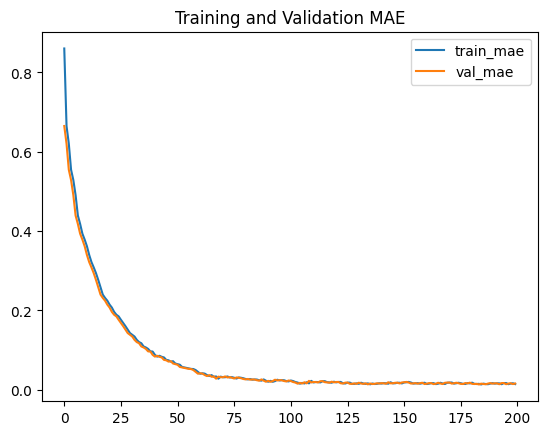

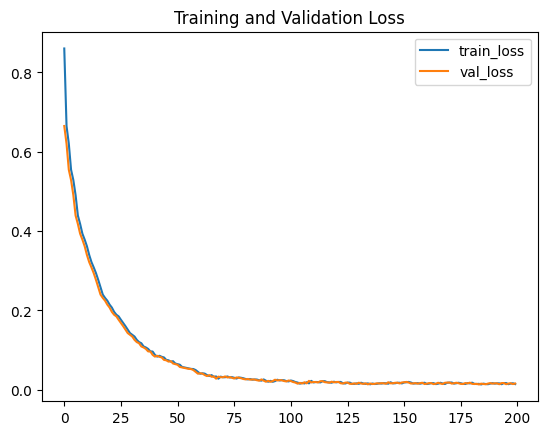

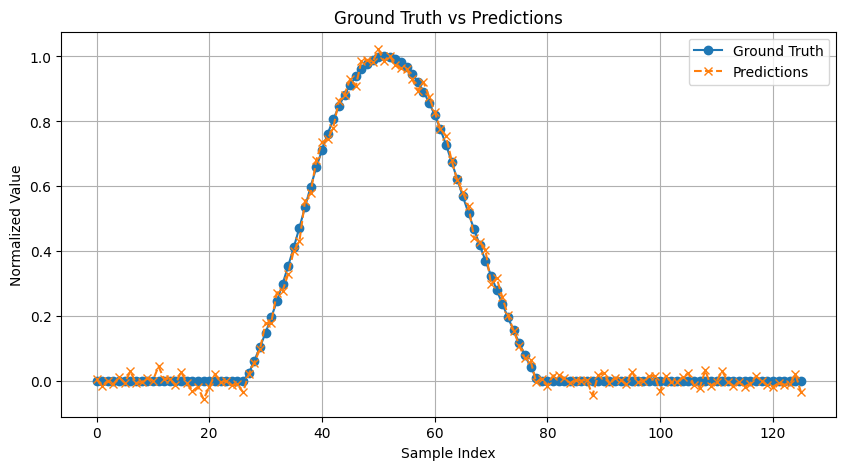

Percent Error: 6.51%
R² Score: 1.00
Relative Accuracy: 93.49%


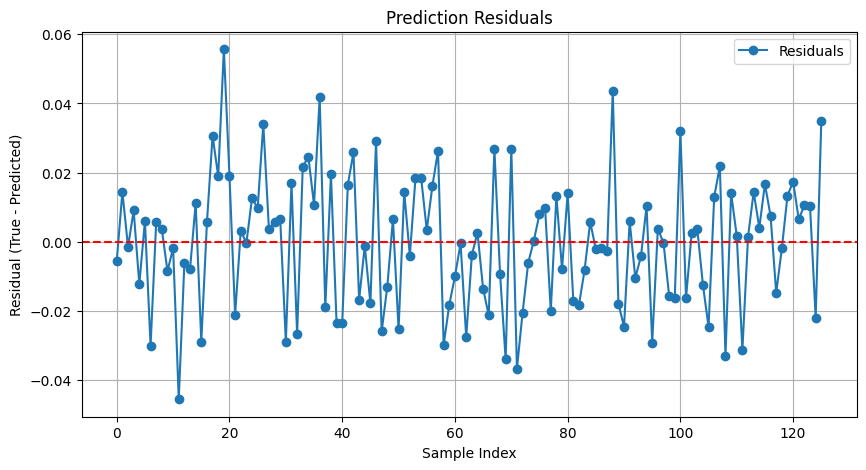

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Enable dynamic GPU memory allocation to allow memory growth
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

BATCH_SIZE = 4          # Batch size for training
EPOCHS = 200            # Number of epochs for training
LR = 1e-4               # Learning rate for the optimizer
PATCH_SIZE = 16         # Size of spatial patches (both height and width)
NUM_LAYERS = 4          # Number of Transformer encoder layers
NUM_HEADS = 4           # Number of attention heads in the Transformer
MLP_DIM = 256           # Hidden dimension for the MLP in Transformer
EMBED_DIM = 128         # Embedding dimension per token
DROPOUT_RATE = 0.1      # Dropout rate for regularization

def save_video_and_labels(video, labels, save_dir):
    """
    Save video data and corresponding labels as numpy files in the specified directory.
    
    Parameters:
    video (np.ndarray): Video data array.
    labels (np.ndarray): Labels corresponding to the video data.
    save_dir (str): Directory path where the files will be saved.
    """
    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, 'video_1.npy'), video)
    np.save(os.path.join(save_dir, 'label_1.npy'), labels)

# Load raw dataset from a .npy file
raw_data = np.load("2023-11-15-cine-myo-masks-and-TOS.npy", allow_pickle=True)
mask_volume = raw_data[0]['cine_lv_myo_masks_cropped']  # shape: (T, H, W)
tos_curve = raw_data[0]['TOS']  # shape: (num_targets,)

# Normalize mask_volume to the range [0, 1] and convert to float32
mask_volume = mask_volume.astype("float32")
mask_volume = mask_volume / np.max(mask_volume)

# Normalize tos_curve to the range [0, 1]
tos_curve = (tos_curve - np.min(tos_curve)) / (np.max(tos_curve) - np.min(tos_curve))

# Save processed dataset for both training and validation splits
save_video_and_labels(mask_volume, tos_curve, './dataset/train/')
save_video_and_labels(mask_volume, tos_curve, './dataset/validation/')

def load_custom_cardiac_dataset(base_dir, split="train", target_shape=(64, 32, 32, 1)):
    """
    Load and preprocess the custom cardiac dataset from the specified directory.
    
    Parameters:
    base_dir (str): Base directory containing the dataset.
    split (str): Which split to load ('train' or 'validation').
    target_shape (tuple): Desired shape of the video data (num_frames, height, width, channels).
    
    Returns:
    tf.data.Dataset: A TensorFlow dataset with preprocessed videos and labels.
    """
    video_file = os.path.join(base_dir, split, 'video_1.npy')
    label_file = os.path.join(base_dir, split, 'label_1.npy')

    # Load videos and labels from numpy files
    videos = np.load(video_file)
    labels = np.load(label_file)

    # Add a channel dimension if videos are in grayscale
    if len(videos.shape) == 3:
        videos = np.expand_dims(videos, axis=-1)

    # Resize each frame spatially to the target dimensions
    resized_frames = [tf.image.resize(frame, target_shape[1:3]).numpy() for frame in videos]
    videos = np.stack(resized_frames, axis=0)

    # Ensure temporal alignment by adjusting the number of frames to match target_shape[0]
    num_frames = target_shape[0]
    if videos.shape[0] < num_frames:
        padding = ((0, num_frames - videos.shape[0]), (0, 0), (0, 0), (0, 0))
        videos = np.pad(videos, padding, mode="constant")
    else:
        videos = videos[:num_frames]

    # Add a batch dimension
    videos = np.expand_dims(videos, axis=0)
    labels = np.expand_dims(labels, axis=0)
    
    # Create a TensorFlow dataset from the numpy arrays
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))
    return dataset

# Prepare training and validation datasets with shuffling and batching
train_ds = load_custom_cardiac_dataset("./dataset", split="train", target_shape=(64, 32, 32, 1)).shuffle(10).batch(BATCH_SIZE)
val_ds = load_custom_cardiac_dataset("./dataset", split="validation", target_shape=(64, 32, 32, 1)).batch(BATCH_SIZE)

class MLP(layers.Layer):
    """
    Multi-Layer Perceptron (MLP) layer used within the Transformer encoder block.
    """
    def __init__(self, hidden_dim, dropout_rate, **kwargs):
        """
        Initialize the MLP layer.
        
        Parameters:
        hidden_dim (int): Hidden dimension for the MLP.
        dropout_rate (float): Dropout rate for regularization.
        """
        super().__init__(**kwargs)
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        self.dense1 = layers.Dense(hidden_dim, activation='gelu')
        self.dropout1 = layers.Dropout(dropout_rate)

    def build(self, input_shape):
        """
        Build the second dense layer to project back to the input embedding dimension.
        
        Parameters:
        input_shape (tuple): Shape of the input tensor.
        """
        embed_dim = input_shape[-1]
        self.dense2 = layers.Dense(embed_dim)
        self.dropout2 = layers.Dropout(self.dropout_rate)
        super().build(input_shape)

    def call(self, x):
        """
        Execute the forward pass of the MLP layer.
        
        Parameters:
        x (tf.Tensor): Input tensor.
        
        Returns:
        tf.Tensor: Output tensor after passing through the MLP.
        """
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        return x

class TransformerEncoderBlock(layers.Layer):
    """
    Transformer Encoder Block consisting of a self-attention layer and an MLP with residual connections.
    """
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout_rate, **kwargs):
        """
        Initialize the Transformer encoder block.
        
        Parameters:
        embed_dim (int): Embedding dimension.
        num_heads (int): Number of attention heads.
        mlp_dim (int): Hidden dimension for the MLP.
        dropout_rate (float): Dropout rate for regularization.
        """
        super().__init__(**kwargs)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp_layer = MLP(hidden_dim=mlp_dim, dropout_rate=dropout_rate)

    def call(self, x):
        """
        Execute the forward pass of the Transformer encoder block.
        
        Parameters:
        x (tf.Tensor): Input tensor.
        
        Returns:
        tf.Tensor: Output tensor after applying self-attention and MLP with residual connections.
        """
        # Self-attention sub-layer with normalization and residual connection
        y = self.norm1(x)
        y = self.att(y, y)
        x = x + y
        # MLP sub-layer with normalization and residual connection
        y = self.norm2(x)
        y = self.mlp_layer(y)
        x = x + y
        return x

class PatchEmbedding(layers.Layer):
    """
    Patch Embedding layer that converts video frames into a sequence of flattened patch tokens.
    """
    def __init__(self, embed_dim, patch_size, **kwargs):
        """
        Initialize the Patch Embedding layer.
        
        Parameters:
        embed_dim (int): Dimension of the patch embedding.
        patch_size (int): Size of each spatial patch.
        """
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.patch_size = patch_size

    def build(self, input_shape):
        """
        Build the patch embedding layer by initializing the projection dense layer.
        
        Parameters:
        input_shape (tuple): Shape of the input tensor (B, T, H, W, C).
        """
        self.proj = layers.Dense(self.embed_dim)
        super().build(input_shape)

    def call(self, x):
        """
        Execute the forward pass to generate patch embeddings.
        
        Parameters:
        x (tf.Tensor): Input tensor of shape (B, T, H, W, C).
        
        Returns:
        tuple: A tuple containing the projected patch embeddings and a tuple with the number 
               of patches along height and width.
        """
        B, T, H, W, C = tf.unstack(tf.shape(x))
        num_patches_h = H // self.patch_size
        num_patches_w = W // self.patch_size

        # Reshape input into patches
        x_reshaped = tf.reshape(x, (B, T, num_patches_h, self.patch_size, num_patches_w, self.patch_size, C))
        x_reshaped = tf.transpose(x_reshaped, perm=[0, 1, 2, 4, 3, 5, 6])
        x_reshaped = tf.reshape(x_reshaped, (B, T, num_patches_h*num_patches_w, self.patch_size*self.patch_size*C))

        # Combine temporal and patch dimensions
        x_reshaped = tf.reshape(x_reshaped, (B, T*num_patches_h*num_patches_w, self.patch_size*self.patch_size*C))

        # Project the flattened patches to the embedding dimension
        x_proj = self.proj(x_reshaped)
        return x_proj, (num_patches_h, num_patches_w)

class AddTemporalSpatialPosEmbed(layers.Layer):
    """
    Layer that adds temporal and spatial positional embeddings to the sequence of patch tokens.
    """
    def __init__(self, embed_dim, num_frames, num_patches, **kwargs):
        """
        Initialize the positional embedding layer.
        
        Parameters:
        embed_dim (int): Embedding dimension.
        num_frames (int): Number of frames in the video.
        num_patches (int): Number of patches per frame.
        """
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_frames = num_frames
        self.num_patches = num_patches

        # Class token used for global video representation
        self.cls_token = self.add_weight(name="cls_token",
                                         shape=[1, 1, embed_dim],
                                         initializer="zeros",
                                         trainable=True)
        # Learnable positional embeddings for all tokens (including cls token)
        self.pos_embed = self.add_weight(name="pos_embed",
                                         shape=[1, num_frames*num_patches+1, embed_dim],
                                         initializer=keras.initializers.RandomNormal(stddev=0.02),
                                         trainable=True)

    def call(self, x):
        """
        Add the class token and positional embeddings to the patch token sequence.
        
        Parameters:
        x (tf.Tensor): Input tensor of shape (B, T*N_patches, embed_dim).
        
        Returns:
        tf.Tensor: Tensor with added class token and positional embeddings.
        """
        B = tf.shape(x)[0]
        cls_token = tf.tile(self.cls_token, [B, 1, 1])
        x = tf.concat([cls_token, x], axis=1)
        x = x + self.pos_embed
        return x

class ViViTModel(keras.Model):
    """
    ViViT (Video Vision Transformer) model for video analysis tasks.
    """
    def __init__(self,
                 num_frames,
                 height,
                 width,
                 patch_size,
                 embed_dim,
                 num_layers,
                 num_heads,
                 mlp_dim,
                 dropout_rate,
                 num_outputs,
                 **kwargs):
        """
        Initialize the ViViT model with the specified configuration.
        
        Parameters:
        num_frames (int): Number of frames in the input video.
        height (int): Height of each video frame.
        width (int): Width of each video frame.
        patch_size (int): Size of each spatial patch.
        embed_dim (int): Embedding dimension for patch tokens.
        num_layers (int): Number of Transformer encoder layers.
        num_heads (int): Number of attention heads in each encoder block.
        mlp_dim (int): Hidden dimension for the MLP in the Transformer.
        dropout_rate (float): Dropout rate for regularization.
        num_outputs (int): Number of outputs for the regression head.
        """
        super().__init__(**kwargs)
        self.num_frames = num_frames
        self.height = height
        self.width = width
        self.patch_size = patch_size

        # Ensure that frame dimensions are divisible by patch_size
        assert height % patch_size == 0 and width % patch_size == 0, "Image must be divisible by patch_size."

        # Initialize patch embedding and Transformer encoder layers
        self.patch_embed = PatchEmbedding(embed_dim=embed_dim, patch_size=patch_size)
        self.enc_layers = [
            TransformerEncoderBlock(embed_dim, num_heads, mlp_dim, dropout_rate) for _ in range(num_layers)
        ]

        # Calculate the number of patches per frame
        num_patches_h = height // patch_size
        num_patches_w = width // patch_size
        num_patches = num_patches_h * num_patches_w

        # Initialize positional embedding layer, layer normalization, and the output regression head
        self.pos_embed_layer = AddTemporalSpatialPosEmbed(embed_dim, num_frames, num_patches)
        self.norm = layers.LayerNormalization(epsilon=1e-6)
        self.head = layers.Dense(num_outputs)  # Regression head

    def call(self, x):
        """
        Execute the forward pass of the ViViT model.
        
        Parameters:
        x (tf.Tensor): Input tensor of shape (B, T, H, W, C).
        
        Returns:
        tf.Tensor: Output predictions of shape (B, num_outputs).
        """
        # Convert video frames to patch tokens and project them
        x, _ = self.patch_embed(x)  # (B, T*N_patches, embed_dim)
        # Add temporal and spatial positional embeddings
        x = self.pos_embed_layer(x)  # (B, 1+T*N_patches, embed_dim)
        # Process tokens through Transformer encoder blocks
        for layer in self.enc_layers:
            x = layer(x)
        # Apply layer normalization and extract the class token for prediction
        x = self.norm(x)
        cls_token = x[:, 0]  # (B, embed_dim)
        out = self.head(cls_token)  # (B, num_outputs)
        return out

# Determine the number of regression targets based on the shape of tos_curve
num_targets = tos_curve.shape[0]
# Instantiate the ViViT model with the specified parameters
model = ViViTModel(
    num_frames=64,
    height=32,
    width=32,
    patch_size=PATCH_SIZE,
    embed_dim=EMBED_DIM,
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    mlp_dim=MLP_DIM,
    dropout_rate=DROPOUT_RATE,
    num_outputs=num_targets
)

# Compile the model with the Adam optimizer and mean absolute error loss metric
model.compile(
    optimizer=keras.optimizers.Adam(LR),
    loss='mae',
    metrics=['mae']
)

# Train the model with the training dataset and validate using the validation dataset
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=10,
    validation_steps=5
)

# Evaluate the model on the validation dataset and print the validation MAE
test_loss, test_mae = model.evaluate(val_ds)
print(f"Validation MAE: {test_mae:.4f}")

# Make predictions on one batch from the validation dataset
for videos, labels in val_ds.take(1):
    pred = model.predict(videos)
    print("Prediction: ", pred)
    print("Ground Truth: ", labels[0].numpy())

# Plot training and validation MAE over epochs
plt.figure()
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.legend()
plt.title("Training and Validation MAE")
plt.savefig("training_validation_mae.png")

# Plot training and validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.savefig("training_validation_loss.png")

# Evaluate the model's predictions on a sample batch from the validation dataset
for video_batch, label_batch in val_ds.take(1):
    predictions = model.predict(video_batch)

    # Plot Ground Truth vs Predictions for visual comparison
    plt.figure(figsize=(10, 5))
    plt.plot(label_batch[0].numpy(), label="Ground Truth", marker='o', linestyle='-')
    plt.plot(predictions[0], label="Predictions", marker='x', linestyle='--')
    plt.title("Ground Truth vs Predictions")
    plt.xlabel("Sample Index")
    plt.ylabel("Normalized Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    ground_truth = label_batch[0].numpy()
    pred_values = predictions[0]

    # Compute the percent error between predictions and ground truth
    percent_error = np.sum(np.abs(pred_values - ground_truth)) / np.sum(np.abs(ground_truth)) * 100
    print(f"Percent Error: {percent_error:.2f}%")

    def r2_score(y_true, y_pred):
        """
        Compute the R² (coefficient of determination) score.
        
        Parameters:
        y_true (np.ndarray): True target values.
        y_pred (np.ndarray): Predicted target values.
        
        Returns:
        float: R² score.
        """
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        return 1 - (ss_res / ss_tot)

    def relative_accuracy(y_true, y_pred):
        """
        Compute the relative accuracy as a percentage.
        
        Parameters:
        y_true (np.ndarray): True target values.
        y_pred (np.ndarray): Predicted target values.
        
        Returns:
        float: Relative accuracy percentage.
        """
        mae_val = np.mean(np.abs(y_true - y_pred))
        return 100 * (1 - mae_val / np.mean(y_true))

    # Calculate R² Score and Relative Accuracy metrics
    r2 = r2_score(ground_truth, pred_values)
    rel_acc = relative_accuracy(ground_truth, pred_values)

    print(f"R² Score: {r2:.2f}")
    print(f"Relative Accuracy: {rel_acc:.2f}%")

    # Plot the residuals (differences between true values and predictions)
    residuals = ground_truth - pred_values
    plt.figure(figsize=(10, 5))
    plt.plot(residuals, label="Residuals", marker='o')
    plt.axhline(0, color='r', linestyle='--')
    plt.title("Prediction Residuals")
    plt.xlabel("Sample Index")
    plt.ylabel("Residual (True - Predicted)")
    plt.legend()
    plt.grid(True)
    plt.show()
